In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import datetime
import sys
sys.path.append('..')
import src.tools as tools

In [2]:
#RFM Libraries
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import kruskal
from sklearn.decomposition import PCA

#CLTV Libraries:
from datetime import datetime, timedelta,date
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [3]:
a = pd.read_csv('../data/Year 2009-2010.csv', encoding='unicode_escape')
b = pd.read_csv('../data/Year 2010-2011.csv', encoding='unicode_escape')
retail = pd.concat([a,b], ignore_index=True)

In [4]:
retail.columns= retail.columns.str.lower()
retail.drop_duplicates(inplace=True)
retail = retail.query("country=='United Kingdom'").reset_index(drop=True)
retail.invoicedate = pd.to_datetime(retail.invoicedate)
retail['year'] = retail.invoicedate.dt.year
retail['month'] = retail.invoicedate.dt.month
retail['week'] = retail.invoicedate.dt.isocalendar().week
retail['day'] = retail.invoicedate.dt.day
retail['hour'] = retail.invoicedate.dt.hour
retail['revenue'] = retail.price * retail.quantity
#retail = retail.query("year>2009").reset_index(drop=True)
retail = retail.query("quantity>0").reset_index(drop=True)
retail = retail.query("price>0").reset_index(drop=True)
retail = retail.dropna()

#### Define customers time

In [5]:
min_date = retail.groupby(['customer id'])['invoicedate'].min().reset_index()
max_date = retail.groupby(['customer id'])['invoicedate'].max().reset_index()
min_date.columns = ['customer id', 'min_date']
max_date.columns = ['customer id', 'max_date']
min_date = pd.merge(min_date, max_date, on='customer id')
min_date['customer_months'] = min_date['max_date'] - min_date['min_date']
min_date['customer_months'] = min_date['customer_months'] / np.timedelta64(1,'M')
min_date['customer_months'] = min_date['customer_months'].astype(int)
min_date.drop(columns=['min_date','max_date'], inplace=True)
retail = pd.merge(retail, min_date, on='customer id')
retail.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,49,1,7,83.4,19
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,49,1,7,81.0,19
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,49,1,7,81.0,19
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,49,1,7,100.8,19
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,49,1,7,30.0,19


In [6]:
retail.customer_months.describe()

count    700388.000000
mean         16.152206
std           7.573422
min           0.000000
25%          11.000000
50%          19.000000
75%          23.000000
max          24.000000
Name: customer_months, dtype: float64

In [7]:
(retail.customer_months.value_counts(normalize=True)*100).sort_index()

0      5.924573
1      1.657938
2      1.658938
3      1.936355
4      1.731326
5      1.252020
6      1.343684
7      1.658367
8      1.966767
9      1.457335
10     1.591118
11     2.834143
12     3.810174
13     3.471504
14     2.956219
15     2.288731
16     3.080150
17     3.271615
18     3.580158
19     5.148575
20     6.626042
21     5.734393
22     6.366043
23    18.780590
24     9.873242
Name: customer_months, dtype: float64

#### Analyze 12-months customers

In [8]:
retail2y = retail.query('customer_months==23').reset_index(drop=True)
retail2y.sample(3)

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months
23938,576172,22114,HOT WATER BOTTLE TEA AND SYMPATHY,24,2011-11-14 11:00:00,3.75,15482.0,United Kingdom,2011,11,46,14,11,90.0,23
114130,522987,22575,METAL MERRY CHRISTMAS WREATH,2,2010-09-19 14:51:00,1.95,17625.0,United Kingdom,2010,9,37,19,14,3.9,23
52110,505708,84406B,CREAM CUPID HEARTS COAT HANGER,2,2010-04-25 12:15:00,3.25,13782.0,United Kingdom,2010,4,16,25,12,6.5,23


#### Segmentation

In [9]:
df_2y = tools.rfm(retail2y)
df_2y.sample(3)

,customer id,recency,frequency,monetary
69,18229.0,11,201,10150.51
300,13427.0,18,52,1006.53
180,14593.0,20,611,3665.53


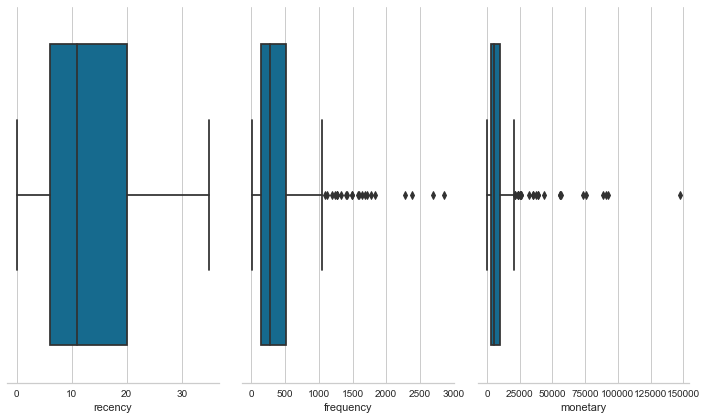

In [10]:
f, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.despine(left=True)

sns.boxplot(x=df_2y.recency, color="b", ax=axes[0])
sns.boxplot(x=df_2y.frequency, color="b", ax=axes[1])
sns.boxplot(x=df_2y.monetary, color="b",ax=axes[2])

plt.tight_layout();

In [11]:
df_2y['z_recency'] = stats.zscore(df_2y.recency)
df_2y['z_frequency'] = stats.zscore(df_2y.frequency)
df_2y['z_monetary'] = stats.zscore(df_2y.monetary)
df_2y.shape

(315, 7)

In [12]:
df_2y = df_2y[(df_2y.z_recency >= -3) & (df_2y.z_recency <= 3) &
         (df_2y.z_frequency >= -3) & (df_2y.z_frequency <= 3) &
         (df_2y.z_monetary >= -3) & (df_2y.z_monetary <= 3)]

In [13]:
df_2y.drop(columns='customer id').describe()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,13.006623,377.910596,7012.606825,0.004648,-0.091572,-0.152257
std,8.958373,341.943005,6776.745802,1.002400,0.789377,0.453730
min,0.000000,9.000000,229.500000,-1.450732,-0.943204,-0.606412
25%,6.000000,145.000000,2753.925000,-0.779360,-0.629247,-0.437392
50%,12.000000,266.500000,4877.695000,-0.107988,-0.348764,-0.295197
75%,20.000000,493.000000,9027.152500,0.787175,0.174113,-0.017375
max,35.000000,1712.000000,43515.051000,2.465604,2.988181,2.291726


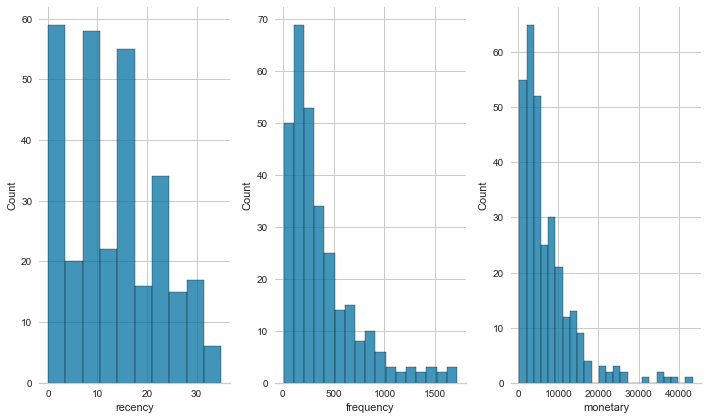

In [14]:
f, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.despine(left=True)

sns.histplot(df_2y.recency, color="b", ax=axes[0])
sns.histplot(df_2y.frequency, color="b", ax=axes[1])
sns.histplot(df_2y.monetary, color="b",ax=axes[2])

plt.tight_layout();

In [15]:
print(stats.jarque_bera(df_2y.recency)[1] < 0.05)
print(stats.jarque_bera(df_2y.frequency)[1] < 0.05)
print(stats.jarque_bera(df_2y.monetary)[1] < 0.05)

True
True
True


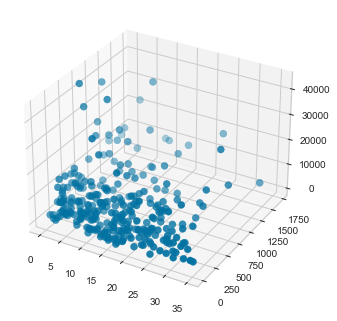

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(df_2y.recency, df_2y.frequency, df_2y.monetary, s=50)

plt.show()

#### Define number of clusters using elbow method

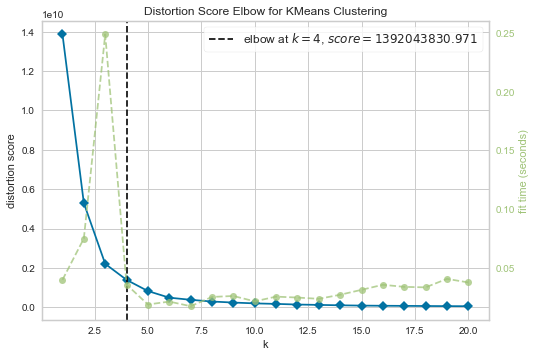

In [17]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,21))

visualizer.fit(df_2y[['recency', 'frequency', 'monetary']])
visualizer.show();

#### Run clustering based on Recency, Frequency and Money

In [18]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_2y[['recency', 'frequency', 'monetary']])
df_2y['clusters'] = kmeans.predict(df_2y[['recency', 'frequency', 'monetary']])
df_2y.sample(3)

,customer id,recency,frequency,monetary,z_recency,z_frequency,z_monetary,clusters
189,13426.0,0,343,8167.38,-1.450732,-0.172163,-0.074940,3
113,13448.0,15,533,8745.93,0.227698,0.266453,-0.036204,3
42,14467.0,16,303,2203.24,0.339593,-0.264503,-0.474263,0


In [19]:
(df_2y.clusters.value_counts(normalize=True)*100).sort_index()

0    63.576159
1     1.986755
2     7.615894
3    26.821192
Name: clusters, dtype: float64

In [20]:
df_2y.drop(columns='customer id').groupby(['clusters']).median()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
clusters,,,,,,
0,14.0,196.5,3192.04,0.115803,-0.510359,-0.408059
1,3.5,720.5,36437.86,-1.059098,0.699298,1.817880
2,9.0,771.0,17467.24,-0.443674,0.815877,0.547722
3,11.0,474.0,9762.77,-0.219883,0.130251,0.031878


In [21]:
weighted = df_2y.drop(columns='customer id').groupby(['clusters']).median()
weighted['recency'] = weighted['recency']/weighted['recency'].min()
weighted['frequency'] = weighted['frequency']/weighted['frequency'].max()
weighted['monetary'] = weighted['monetary']/weighted['monetary'].max()
weighted['segment'] = (weighted.frequency * weighted.monetary) / weighted.recency
weighted['segment'] = weighted.segment.rank(ascending=False)
weighted.sort_values(by='segment')

,recency,frequency,monetary,z_recency,z_frequency,z_monetary,segment
clusters,,,,,,,
1,1.000000,0.934501,1.000000,-1.059098,0.699298,1.817880,1.0
2,2.571429,1.000000,0.479371,-0.443674,0.815877,0.547722,2.0
3,3.142857,0.614786,0.267929,-0.219883,0.130251,0.031878,3.0
0,4.000000,0.254864,0.087602,0.115803,-0.510359,-0.408059,4.0


In [22]:
df_2y = pd.merge(df_2y, weighted['segment'], on='clusters')
df_2y.drop(columns=['clusters', 'z_recency', 'z_frequency','z_monetary'], inplace=True)
df_2y.sample(3)

,customer id,recency,frequency,monetary,segment
235,14291.0,1,494,7904.10,3.0
57,17157.0,7,141,5151.90,4.0
214,15382.0,14,632,13733.55,3.0


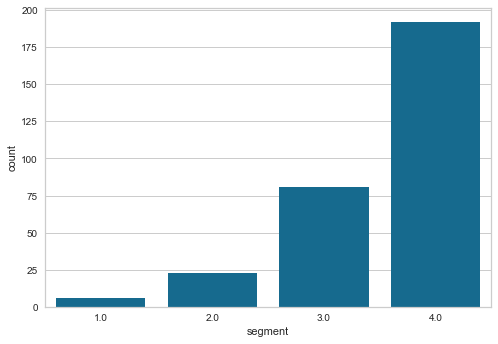

In [23]:
sns.countplot(x=df_2y.segment, color="b");

In [24]:
df_2y.segment.value_counts(normalize=True)*100

4.0    63.576159
3.0    26.821192
2.0     7.615894
1.0     1.986755
Name: segment, dtype: float64

In [25]:
retail2y = pd.merge(retail2y, df_2y[['customer id', 'segment']], on='customer id')
retail2y.sample(3)

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months,segment
49868,517969,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,3,2010-08-03 13:07:00,0.85,13984.0,United Kingdom,2010,8,31,3,13,2.55,23,4.0
111989,500310,22459,CAST IRON HOOK GARDEN TROWEL,8,2010-03-07 11:24:00,2.55,15270.0,United Kingdom,2010,3,9,7,11,20.40,23,3.0
75077,575504,22456,NATURAL SLATE CHALKBOARD LARGE,3,2011-11-10 10:29:00,4.95,14895.0,United Kingdom,2011,11,45,10,10,14.85,23,2.0


In [26]:
seg_rev = retail2y.groupby(['year','month','segment'])['revenue'].sum().unstack().fillna(0)
seg_rev

segment           1.0       2.0       3.0       4.0
year month                                         
2009 12     13109.080  32740.61  55875.39  72748.19
2010 1      12538.171  13036.41  27199.05  23031.42
     2       5044.110  15737.34  30083.48  15621.24
     3       8822.250  16330.82  33404.63  23139.37
     4      10336.080  22203.10  31639.82  17320.73
     5       6933.110  17409.24  31546.88  18736.98
     6       8673.940  19688.72  30416.52  21989.59
     7      10307.350  15072.21  26535.68  18880.80
     8       6830.260  19952.97  31052.62  18256.56
     9      19240.830  14281.54  35832.27  25615.89
     10     10206.170  22784.02  40843.70  36203.04
     11     13180.150  34715.15  66411.76  55770.27
     12      7024.190  20038.49  41503.24  33664.67
2011 1       6496.890  11797.40  26899.51  14571.16
     2       7911.610  13802.34  22175.87  10537.42
     3       6319.330  11447.33  21347.99  17341.99
     4       4997.280  13697.42  22182.29  10815.53
     5       8637.240  13872.18  26092.25  18551.99
     6       3823.920  10827.40  26358.41  17092.48
     7       9599.030  11892.09  22849.56  14620.22
     8       7063.530  16976.42  26434.23  15152.61
     9      10029.610  21761.27  30731.94  25369.18
     10      9885.530  24352.18  30583.09  25636.75
     11     12799.040  26695.10  65283.72  60722.99
     12      2711.380   7542.08  13451.64  18506.74

In [27]:
retail2y[['invoicedate', 'revenue']]

,invoicedate,revenue
0,2009-12-01 09:57:00,10.20
1,2009-12-01 09:57:00,10.20
2,2009-12-01 09:57:00,20.40
3,2009-12-01 09:57:00,10.20
4,2009-12-01 09:57:00,19.90
...,...,...
114124,2011-11-28 16:35:00,14.85
114125,2011-11-28 16:35:00,25.20
114126,2011-11-28 16:35:00,19.80
114127,2011-11-28 16:35:00,15.00


In [28]:
retail2y.invoicedate = pd.to_datetime(retail2y.invoicedate).dt.normalize()
cluster1 = retail2y[retail2y.segment == 1]
cluster1 = cluster1[['invoicedate', 'revenue']]
cluster1.shape

(5041, 2)

In [29]:
cluster2 = retail2y[retail2y.segment == 2]
cluster2 = cluster2[['invoicedate', 'revenue']]
cluster2.shape

(18108, 2)

In [30]:
cluster3 = retail2y[retail2y.segment == 3]
cluster3 = cluster3[['invoicedate', 'revenue']]
cluster3.shape

(45455, 2)

In [31]:
cluster4 = retail2y[retail2y.segment == 4]
cluster4 = cluster4[['invoicedate', 'revenue']]
cluster4.shape

(45525, 2)

In [32]:
"""cluster1.to_csv('../data/ts_segment1.csv',index=False)
cluster2.to_csv('../data/ts_segment2.csv',index=False)
cluster3.to_csv('../data/ts_segment3.csv',index=False)
cluster4.to_csv('../data/ts_segment4.csv',index=False)""";

In [33]:
def clean_ts (df):
    df.columns = ['ds','y']
    df.ds = pd.to_datetime(df.ds).dt.strftime('%Y-%m')
    
    df['z_score'] = stats.zscore(df.y)
    df = df[(df.z_score >= -3) & (df.z_score <= 3)]
    df = df.drop(columns='z_score')
    df.set_index('ds', inplace=True)
    return df

In [34]:
k1 = clean_ts(cluster1)
k2 = clean_ts(cluster2)
k3 = clean_ts(cluster3)
k4 = clean_ts(cluster4)

In [35]:
"""f, axes = plt.subplots(2, 2, figsize=(10, 6))
sns.despine(left=True)

sns.lineplot(data=k1, x='ds', y='y', color="b", ax=axes[0,0])
sns.lineplot(data=k2, x='ds', y='y', color="b", ax=axes[0,1])
sns.lineplot(data=k3, x='ds', y='y', color="b", ax=axes[1,0])
sns.lineplot(data=k4, x='ds', y='y', color="b", ax=axes[1,1])

plt.show();""";

In [ ]:
sns.lineplot(x=k1.index,y=k1.y)